# Cleaning - missing and duplicate data

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Generate a t-shirt order
have a name, a t-shirt size, a t-shirt color and a weight(in pounds)<br>
Uses the <a href="https://pypi.org/project/names/https://pypi.org/project/names/">names </a> module to generate random names

In [28]:
import utils as ut

In [29]:
import utils as ut
df = ut.generate_tshirt_order()
df

,weight,t_shirt_size,t_shirt_color,name
0,89.679763,small,orange,Luther Morgan
1,102.264289,small,black,Marie Anthony
2,91.729683,small,red,Tom Picciano
3,96.598349,small,green,Eric Heiskell
4,92.211435,small,orange,Robin Owensby
...,...,...,...,...
295,209.111902,large,orange,Gwen Baker
296,184.111878,large,blue,Madeline Jackson
297,166.845307,large,blue,Louis Vazquez
298,122.214513,large,green,April Haneke


### Make some duplicates

In [30]:
# make some duplicates just to show how to handle duplicates (delete them)
#lets find the oldest male and female
def fun1(df,numb=5):
    #generates numb rows from df
    return (df.iloc[0:numb,:])


#generates numb rows from each group to be used as duplicates
df_dups=df.groupby('t_shirt_size').apply(fun1)
df_dups

weight t_shirt_size t_shirt_color               name
t_shirt_size                                                              
large        200  183.126252        large        orange      William White
             201  142.709728        large         black       Angelo Joyce
             202  189.967197        large         black      Aubrey Berner
             203  207.499851        large        orange    Dale Richardson
             204  219.516286        large         green       Ray Stiltner
medium       100  154.015782       medium         green   Michael Dinsmore
             101  149.417365       medium         green  Charlie Schupbach
             102  111.165122       medium         green    Martha Williams
             103  141.539545       medium         black     Harold Osborne
             104  106.289561       medium          blue      Emily Collins
small        0     89.679763        small        orange      Luther Morgan
             1    102.264289        small         black      Marie Anthony
             2     91.729683        small           red       Tom Picciano
             3     96.598349        small         green      Eric Heiskell
             4     92.211435        small        orange      Robin Owensby

### Append to original dataframe

In [31]:
df=pd.concat([df,df_dups],ignore_index=True)
#the old, soon to be deprecated way
# df=df.append(df_dups, ignore_index=True)
len(df)

315

In [32]:
df.name.duplicated().sum()

15

### randomly select 20% of rows for t_shirt_size ommision

In [33]:
#first save orig size for later comparison
df['t_shirt_size_orig'] = df['t_shirt_size']

In [34]:
import random
res = random.sample(range(0, len(df)), int(0.2 * len(df)))
print(f'Number of rows to have "t_shirt_size" set to np.Nan is {len(res)}' )

Number of rows to have "t_shirt_size" set to np.Nan is 63


In [35]:
#first, save orig size
df['t_shirt_size_orig'] = df.loc[res,'t_shirt_size']

#then lose orig size
df.loc[res,'t_shirt_size']=np.NaN

In [36]:
#how many total
#df.isna().sum().sum()

#how many are null?
df.t_shirt_size.isna().sum()

63

In [37]:
#show the missing data
df[df.t_shirt_size.isna()]

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
1,102.264289,NaN,black,Marie Anthony,small
8,91.541000,NaN,orange,Timothy Vassel,small
10,102.928492,NaN,black,Christina Smith,small
17,140.222122,NaN,blue,Jessica Ohmen,small
30,105.959706,NaN,red,Sid Grover,small
33,94.744337,NaN,green,Myra Garcia,small
35,88.451631,NaN,orange,Patricia Belser,small
36,68.840832,NaN,orange,Susanne Daigle,small
47,114.916642,NaN,blue,Christine Rodocker,small
50,110.883944,NaN,blue,Shannon Spalding,small


In [38]:
df.head()

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
0,89.679763,small,orange,Luther Morgan,NaN
1,102.264289,NaN,black,Marie Anthony,small
2,91.729683,small,red,Tom Picciano,NaN
3,96.598349,small,green,Eric Heiskell,NaN
4,92.211435,small,orange,Robin Owensby,NaN


### Lets take a look at the distribution

#### kind ='hist', hist will bin the number of weights and display them, hue will determine which color group they belong to

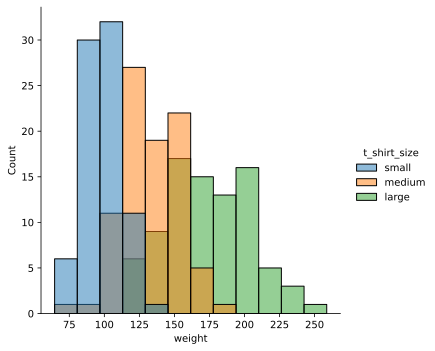

In [39]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='hist', fill=True);

#### kind ='kde', kde is a kernel density estimater, essentially calculates a gaussian distribution around each point, and then adds these distributions, and then divides by the number of points to get the smooth curves you see that have an area of 1.  I'm showing it because its easier to see the distributions

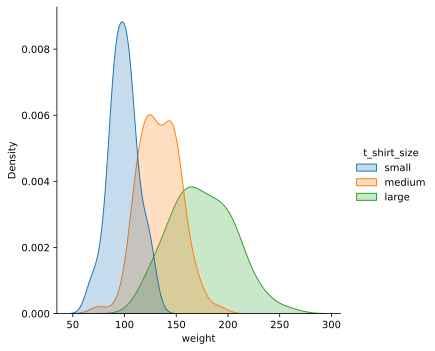

In [40]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='kde', fill=True);

df.t_shirt_size.value_counts()## What to do about duplicates?  Delete them!

### Find them first

In [41]:
df.duplicated(keep=False).sum()

24

### Visually Verify 

In [42]:
df[df.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
301,142.709728,large,black,Angelo Joyce,NaN
201,142.709728,large,black,Angelo Joyce,NaN
302,189.967197,large,black,Aubrey Berner,NaN
202,189.967197,large,black,Aubrey Berner,NaN
306,149.417365,medium,green,Charlie Schupbach,NaN
101,149.417365,medium,green,Charlie Schupbach,NaN
313,96.598349,small,green,Eric Heiskell,NaN
3,96.598349,small,green,Eric Heiskell,NaN
308,141.539545,medium,black,Harold Osborne,NaN
103,141.539545,medium,black,Harold Osborne,NaN


### Looks good lets dump them

In [43]:
#dont do this see below
df.drop_duplicates(inplace=True)

## What if one of the duplicated rows is missing the t-shirt size?  Then duplicated() will not find it.  Maybe we should check for duplicates in the 'name' column instead

In [44]:
df.name.duplicated(keep=False).sum()

6

### Verify that they are duplicates first

In [45]:
df[df.name.duplicated(keep=False)].sort_values(by='name')

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
203,207.499851,NaN,orange,Dale Richardson,large
303,207.499851,large,orange,Dale Richardson,NaN
104,106.289561,medium,blue,Emily Collins,NaN
309,106.289561,NaN,blue,Emily Collins,medium
4,92.211435,small,orange,Robin Owensby,NaN
314,92.211435,NaN,orange,Robin Owensby,small


### We want to delete the one that has a np.nan for t_shirt_size.

In [46]:
df.drop( df[df.name.duplicated(keep=False) & (df.t_shirt_size.isna())].index, inplace=True)

### Now drop the regular duplicates that are not missing data

In [47]:
df.drop( df[df.name.duplicated(keep=False)].index, inplace=True)

## Duplicates are gone, now how to impute the missing fields

In [48]:
len(df[(df['t_shirt_size'].isnull())])

59

In [49]:
df

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
0,89.679763,small,orange,Luther Morgan,NaN
1,102.264289,NaN,black,Marie Anthony,small
2,91.729683,small,red,Tom Picciano,NaN
3,96.598349,small,green,Eric Heiskell,NaN
4,92.211435,small,orange,Robin Owensby,NaN
...,...,...,...,...,...
296,184.111878,large,blue,Madeline Jackson,NaN
297,166.845307,large,blue,Louis Vazquez,NaN
298,122.214513,large,green,April Haneke,NaN
299,169.878747,large,orange,David Eddy,NaN


In [50]:
# how many match
def printstats(df):
    tmp = df[df['t_shirt_size_orig'].notnull()]
    numb=len(tmp)
    numbmatches=(tmp['t_shirt_size_orig']==tmp['t_shirt_size']).sum()
    print(f'Correctly imputed {numbmatches} out of {numb} missing values')

### One way is to use SimpleImputer and assign the median value to all the missing values


In [51]:
df_med=df.copy()
df_med

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
0,89.679763,small,orange,Luther Morgan,NaN
1,102.264289,NaN,black,Marie Anthony,small
2,91.729683,small,red,Tom Picciano,NaN
3,96.598349,small,green,Eric Heiskell,NaN
4,92.211435,small,orange,Robin Owensby,NaN
...,...,...,...,...,...
296,184.111878,large,blue,Madeline Jackson,NaN
297,166.845307,large,blue,Louis Vazquez,NaN
298,122.214513,large,green,April Haneke,NaN
299,169.878747,large,orange,David Eddy,NaN


In [55]:
df[df.t_shirt_size.isnull()]

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
1,102.264289,NaN,black,Marie Anthony,small
8,91.541000,NaN,orange,Timothy Vassel,small
10,102.928492,NaN,black,Christina Smith,small
17,140.222122,NaN,blue,Jessica Ohmen,small
30,105.959706,NaN,red,Sid Grover,small
33,94.744337,NaN,green,Myra Garcia,small
35,88.451631,NaN,orange,Patricia Belser,small
36,68.840832,NaN,orange,Susanne Daigle,small
47,114.916642,NaN,blue,Christine Rodocker,small
50,110.883944,NaN,blue,Shannon Spalding,small


In [54]:
df.t_shirt_size.value_counts()

medium    83
large     81
small     77
Name: t_shirt_size, dtype: int64

In [58]:
df_med.t_shirt_size.value_counts()

medium    142
large      81
small      77
Name: t_shirt_size, dtype: int64

In [56]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent',add_indicator=True)  #works with strings
imp = imp.fit(df_med[['t_shirt_size']])   #here is where it determines what the most frequent is
df_med['t_shirt_size']=imp.transform(df_med[['t_shirt_size']])  #here is where the transform is applied 

In [48]:
df_med

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig
0,82.490016,small,green,Doris Hannon,NaN
1,79.932274,small,orange,Pamela Saul,NaN
2,111.519103,small,blue,Philip Spicer,NaN
3,96.158981,small,green,Marian Green,NaN
4,105.590058,small,blue,Clara Forbes,NaN
...,...,...,...,...,...
297,183.089245,large,blue,Derrick Dees,NaN
298,194.477293,large,blue,Andrew Bunn,NaN
299,144.630539,small,black,Matthew Claar,large
301,167.374676,large,green,Donald Napoleon,NaN


In [59]:
printstats(df_med)

Correctly imputed 17 out of 59 missing values


In [37]:
#show calculated verses actual
# df_med[df_med['t_shirt_size'].isna()]

### Another way is to find the mean weight for each t-shirt size, and then assign missing value t-shirt size based on weight
For each NaN, assign t-shirt size to closest mean

#### First calculate average weight for each t-shirt size

In [82]:
df_better = df.copy()

In [83]:
avgs = df_better.groupby('t_shirt_size').mean()
avgs.weight

t_shirt_size
large     174.454256
medium    133.693181
small      99.366986
Name: weight, dtype: float64

In [84]:
#how many in each group
# df_better.groupby('t_shirt_size').count()

#### Impute the value, replace any NaNs, and add a 1 in a column to indicate that this value was imputed 
<mark>The indicater column will inform a ML algorithm that this value was imputed

In [86]:
#map works on a column apply works on a row, which means we have access tothe entire row
#can also return more than 1 value so that we can have an indicator value

def func(row):
    if row.t_shirt_size is np.NaN:
        #which avgs.weight is this weight closest to?
        
        #get a list of differences between this weight and average weights
        lst_vals = [abs(row.weight-val) for val in avgs.weight]

        #get the index of the minimum value
        min_val = min(lst_vals)
        min_index=lst_vals.index(min_val)

        #return t_shirt_size corresponding to this index
        return pd.Series([avgs.index[min_index],True],index=['t_shirt_size','t_shirt_size_indicator'])
    #its not missing, return what's there
    return pd.Series([row.t_shirt_size,False],index=['t_shirt_size','t_shirt_size_indicator'])
# df_better['t_shirt_size_indicator']=False
df_better[['t_shirt_size','t_shirt_size_indicator']]=df_better.apply(func, axis=1)

In [87]:
printstats(df_better)

Correctly imputed 49 out of 59 missing values


In [88]:
#see which ones it got wrong, look at the distributions in above plots
#it got them wrong because the weights were outliers
df_better[(df_better['t_shirt_size_indicator'])]

,weight,t_shirt_size,t_shirt_color,name,t_shirt_size_orig,t_shirt_size_indicator
1,102.264289,small,black,Marie Anthony,small,True
8,91.541000,small,orange,Timothy Vassel,small,True
10,102.928492,small,black,Christina Smith,small,True
17,140.222122,medium,blue,Jessica Ohmen,small,True
30,105.959706,small,red,Sid Grover,small,True
33,94.744337,small,green,Myra Garcia,small,True
35,88.451631,small,orange,Patricia Belser,small,True
36,68.840832,small,orange,Susanne Daigle,small,True
47,114.916642,small,blue,Christine Rodocker,small,True
50,110.883944,small,blue,Shannon Spalding,small,True


# Generate Slide for the lecture

In [41]:
def func(df, numb=5):
    return (df.iloc[0:numb,:])
    
df.groupby('t_shirt_size', dropna=False).apply(func,numb=3)

weight t_shirt_size t_shirt_color             name  \
t_shirt_size                                                               
large        205  123.860665        large           red       Greg Suter   
             206  109.926978        large         green  Kathryn Mccarty   
             208  208.878019        large          blue    Helen Elliott   
medium       102  156.830687       medium         green     Gary Hutzler   
             106  121.699911       medium        orange   Victoria Gamez   
             109  177.492439       medium          blue      Alice Helms   
small        4     75.660009        small           red   Timothy Franks   
             5     93.685290        small         black      Nellie Wood   
             6     99.534443        small          blue     Sandra Garza   
NaN          7    105.643369          NaN         black       Anna Otter   
             14    89.624467          NaN          blue       Dawn Bryan   
             20    98.182341          NaN           red    Chris Mcsween   

                 t_shirt_size_orig  
t_shirt_size                        
large        205               NaN  
             206               NaN  
             208               NaN  
medium       102               NaN  
             106               NaN  
             109               NaN  
small        4                 NaN  
             5                 NaN  
             6                 NaN  
NaN          7               small  
             14              small  
             20              small